In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

In [54]:
# Load the data
df = pd.read_excel("C:/Users/baner/Documents/Planet-Hunt/data/Study_of_exoplanets.xlsx")

# Data preprocessing
feature_columns = ['P_MASS', 'P_RADIUS', 'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 
                   'P_INCLINATION', 'P_ESCAPE', 'P_POTENTIAL'
                   ]  

target_column = 'P_HABITABLE'

# Data preprocessing
for col in feature_columns:
    df.fillna({col: df[col].median()}, inplace=True)

df_cleaned = df[feature_columns + [target_column]]

# Display the cleaned DataFrame
print(df_cleaned.head())

       P_MASS  P_RADIUS    P_PERIOD  P_SEMI_MAJOR_AXIS  P_ECCENTRICITY  \
0  6165.86330   2.33168   326.03000               1.29           0.231   
1  4684.78480   2.33168   516.21997               1.53           0.080   
2  1525.57440   2.33168   185.84000               0.83           0.000   
3  1481.07850   2.33168  1773.40000               2.93           0.370   
4   565.73385   2.33168   798.50000               1.66           0.680   

   P_INCLINATION  P_ESCAPE  P_POTENTIAL  P_HABITABLE  
0           88.1  3.876993    15.031085            0  
1           88.1  3.876993    15.031085            0  
2           88.1  3.876993    15.031085            0  
3           88.1  3.876993    15.031085            0  
4           88.1  3.876993    15.031085            0  


In [55]:
# Features and target variable
X = df_cleaned[['P_MASS', 'P_RADIUS', 'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 
          'P_INCLINATION', 'P_ESCAPE', 'P_POTENTIAL'
          ]]
          
y = df_cleaned['P_HABITABLE']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Compute class weights manually
class_weights = {0: 6.0, 
                 1: 20.0, 
                 2: 20.0
                 }

# DL model
model = keras.Sequential([
    # Input layer
    keras.layers.InputLayer(shape=(X_train_resampled.shape[1],)),

    # Hidden layers
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    
    # Output layer
    keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


# Train the model
history = model.fit(X_train_resampled, y_train_resampled, 
                    validation_split=0.2, 
                    epochs=80, 
                    batch_size=32,
                    class_weight=class_weights
                    )

Epoch 1/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5304 - loss: 10.8635 - val_accuracy: 0.6948 - val_loss: 0.8345
Epoch 2/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7206 - loss: 6.4924 - val_accuracy: 0.8769 - val_loss: 0.4589
Epoch 3/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7995 - loss: 4.8553 - val_accuracy: 0.8998 - val_loss: 0.3664
Epoch 4/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8192 - loss: 4.4236 - val_accuracy: 0.9463 - val_loss: 0.2406
Epoch 5/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8274 - loss: 4.1491 - val_accuracy: 0.8779 - val_loss: 0.4187
Epoch 6/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8390 - loss: 3.9267 - val_accuracy: 0.9176 - val_loss: 0.2816
Epoch 7/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8474 - loss: 3.5806 - val_accuracy: 0.9327 - val_loss: 0.2666
Epoch 8/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8465 - loss: 3.6958 - val_accuracy: 0

In [56]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_acc:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9261 - loss: 0.2370
Test accuracy: 0.9173


In [57]:
# Generate a classification report
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
print(classification_report(y_test, y_pred, target_names=['Uninhabitable Planets', 'Conservatively Habitable Planets', 'Optimistically Habitable Planets']))

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
                                  precision    recall  f1-score   support

           Uninhabitable Planets       1.00      0.92      0.96       799
Conservatively Habitable Planets       0.09      0.75      0.15         4
Optimistically Habitable Planets       0.06      0.29      0.10         7

                        accuracy                           0.92       810
                       macro avg       0.38      0.65      0.40       810
                    weighted avg       0.98      0.92      0.95       810



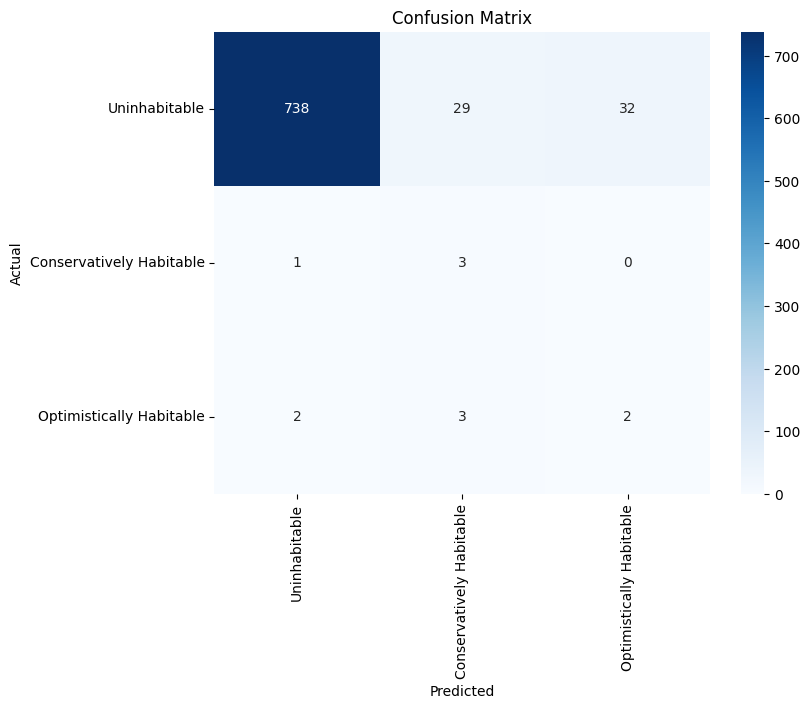

In [58]:
# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninhabitable', 'Conservatively Habitable', 'Optimistically Habitable'], 
            yticklabels=['Uninhabitable', 'Conservatively Habitable', 'Optimistically Habitable'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

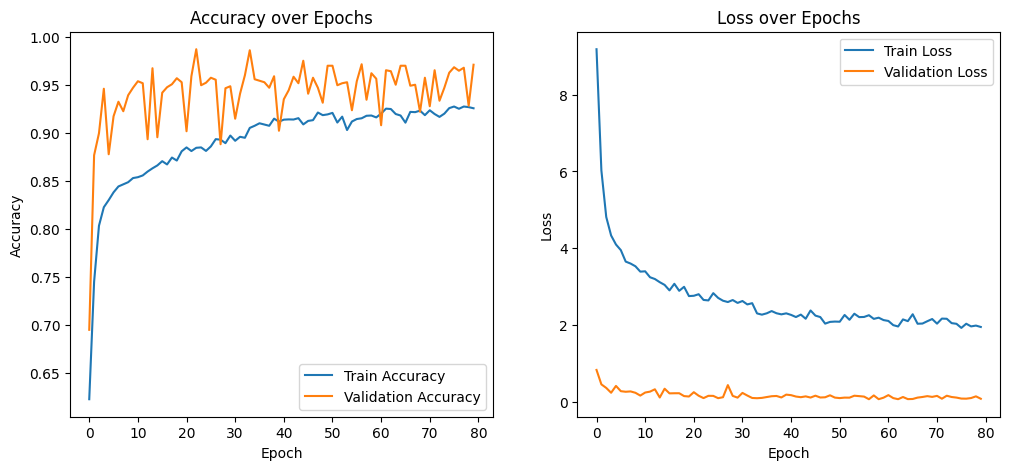

['scaler.pkl']

In [59]:
# Plot the accuracy and loss curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Save the model
model.save('trained_model.h5')

import joblib
joblib.dump(scaler, 'scaler.pkl')

In [60]:
y.value_counts()

P_HABITABLE
0    3993
2      34
1      21
Name: count, dtype: int64